# <u>TP4: Équations différentielles partielles</u>

## par Antoine Boissinot  - -  François Gaudreault  - -  Béatrice Lessard-Hamel

## Présenté à M. Philippe Després

### Date de remise : 4 avril 2021

In [277]:
import matplotlib.pylab as plt
import numpy as np
import timeit
from scipy import constants

In [278]:
#Constants
hbar = constants.hbar #Planck's constant divided by 2*pi [m^2 kg / s]
M = constants.electron_mass #Mass of the electron [kg]
L = 1e-08 #Length of the box [m]
x_0 = L/2 # [m]
sigma = 1e-10 #[m]
kappa = 5e10 #[m^-1]

## L'équation de Schrödinger et la méthode de Crank Nicolson

### Question 1
Le but de ce numéro est d'obtenir le vecteur $\mathbf{v}$ qui est donné par l'équation $\mathbf{B}\psi = \mathbf{v}$. Étant donné que la matrice $\mathbf{B}$ est une matrice tridiagonale, il est possible d'utiliser l'expression suivante pour obtenir les élément $v_i$ de $\mathbf{v}$: $$v_i = b_1 \psi_i + b_2(\psi_{i+1} + \psi_{i-1}).$$ Premièrement la fonction d'onde au temps t = 0 va être obtenue:

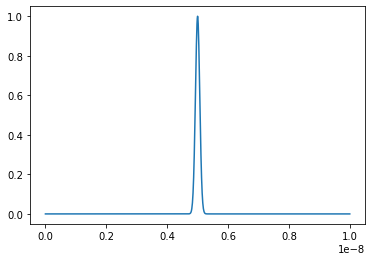

In [292]:
#Parameters of the simulation

N = 1000 #Number of spatial slice 
a = L/N  #Distance between each slice    
h = 10**(-18)  #Step [s]


def psi_0(x): #Return the initial wave function psi (x,0) at time t = 0 
    return exp(-(x - x_0) ** 2 / (2 * sigma ** 2)) * exp(1j * kappa * x)  


def initial_condition(N, L, h): #Set a wave function at time t = 0, with each point in x separated by a
    x = np.linspace(0, L, N+1) #Each point separated by a
    psi = np.array(psi_0(x)) #Initial condition  
    psi[0] = 0 #The wave function equal 0 at discontinuity point i.e. infinite potential value 
    psi[-1] = 0 #Same as last 
    return psi 
    
    
x = np.linspace(0, L, N+1) #Each point separated by a
psi_t0 = initial_condition(N, L, h)
plt.plot(x, abs(psi_t0)**2)
plt.show()

Maintenant, il est possible de de définir le vecteur $\mathbf{v}$: 

In [293]:
def v(psi): #return the vector v
    b1 = 1 - 1j * h * hbar / (2 * M * a ** 2)
    b2 = h * hbar * 1j / (4 * M * a ** 2)
    
    v = np.zeros(len(psi), dtype = complex) #Initialize the vector v 
    n = len(psi) - 1 #Last element of vector v 
    
    
    v[1:n] = b1 * psi[1:n] + b2 * (psi[2:n+1] + psi[0:n-1])
   
    
    return v


v_0 = v(psi_t0)
print(v_0)

[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]


### Question 2
L'objet de ce numéro est de résoudre le système $\mathbf{v} = \mathbf{A}\mathbf{x}$ afin d'obtenir le vecteur $\mathbf{x}$. Pour ce faire l'algorithme de Thomas qui est une forme simplifiée de l'élimination gaussienne. On va premièrement écrire le vecteur sous la forme $$a_{i} x_{i-1}+b_{i} x_{i}+c_{i} x_{i+1}=d_{i}.$$  

In [294]:
def A_tri(N):
    a1 = 1 + 1j * h * hbar / (2 * M * a ** 2)
    a2 = - h * hbar * 1j / (4 * M * a ** 2)
    A = np.zeros([3, N + 1], dtype = complex) #We write the tridiagonal matrix in the good form 
    
    A[0, 0] = 0
    A[0, 1:] = a2
    A[1, :] = a1
    A[2, 0:N] = a2
    A[2, N] = 0
    return A 

M1 = A_tri(N)  

Ensuite, on utilise l'algorithme de Thomas pour résoudre le système. Brièvement, on invente des nouveaux coefficients $c_i^\prime$ et $d_i^\prime$ qui ont les valeurs suivantes:   
$$
c_{i}^{\prime}=\left\{\begin{array}{ll}
\frac{c_{i}}{b_{i}} & ; \quad i=1 \\
\frac{c_{i}}{b_{i}-a_{i} c_{i-1}^{\prime}} & ; \quad i=2,3, \ldots, n-1
\end{array}\right.
$$
et
$$
d_{i}^{\prime}=\left\{\begin{array}{ll}
\frac{d_{i}}{b_{i}} & ; \quad i=1 \\
\frac{d_{i}-a_{i} d_{i-1}^{\prime}}{b_{i}-a_{i} c_{i-1}^{\prime}} & ; \quad i=2,3, \ldots, n
\end{array}\right.
$$


On obtient alors la solution en utilisant les nouveaux coefficients: 
$$x_{n}=d_{n}^{\prime}$$
et 
$$
x_{i}=d_{i}^{\prime}-c_{i}^{\prime} x_{i+1} \quad ; i=n-1, n-2, \ldots, 1 .
$$ 

In [295]:
def Thomas(A_tri, v): 
    """
    The function returns the vector x of the system of equation Ax = v 
    param 1 A: is a triadiagonal matrix written in the form a_{i} * x_{i-1} + b_{i} * x_{i}+ c_{i} * x_{i+1}
    param 2 v: v is the vector of the RHS    
    return: x, the solution of the system  
    """
    N = len(v) - 1 
    c_prime = np.zeros(N, dtype = complex) #Initialization of the vector c' 
    d_prime = np.zeros(N + 1, dtype = complex) #Initialization of the vector d' 
    x = np.zeros(N + 1, dtype = complex) #Initialization of the vector x 
    
    a_ = A_tri[0, :] #Lower diagonal
    b_ = A_tri[1, :] #Middle diagonal
    c_ = A_tri[2, :] #Upper diagonal
    d_ = v[:] #RHS 
    
    c_prime[0] = c_[0]/b_[0] #First element of the new c' vector
    d_prime[0] = d_[0]/b_[0] #First element of the new d' vector
    
    for i in range(1, N):   
        c_prime[i] = c_[i]/(b_[i] - a_[i] * c_prime[i - 1]) #New values of c' 
    
    for i in range(1, N+1): 
        d_prime[i] = (d_[i] - a_[i] * d_prime[i-1])/(b_[i] - a_[i] * c_prime[i-1]) #New values of d'
    
    x[N] = d_prime[N] #Last element of the vector x 
    
    for i in range(N-1, -1, -1):
        x[i] = d_prime[i] - c_prime[i]*x[i+1] #New values of x by substitution of c' and d', from the before last to the first element

        
    return x


On peut vérifier si l'algorithme est fonctionnel en vérifiant si le produit matricielle et entre la matrice $\mathbf{A}$ et le vecteur $\mathbf{x}$ donne bien le vecteur $\mathbf{v}$. 

In [296]:
#First we must write the matrix A in its matrix form 

def A(N):
    
    A = np.zeros([N+1, N+1], dtype = complex) #We initialize the size of the square matrix
    a1 = 1 + 1j * h * hbar / (2 * M * a ** 2)
    a2 = - h * hbar * 1j / (4 * M * a ** 2)
    
    for i in range(N+1): #Middle diagonal
        A[i, i] = a1
    
    for i in range(N):   #Upper diagonal  
        A[i, i+1] = a2 
    
    for i in range(N):   #Lower diagonal
        A[i+1, i] = a2  
    
    return A

M2 = A(N)

#We check if the matrix product Ax = v 

x = Thomas(M1, v_0) #The vector x found by Thomas algorithm 
Ax = np.matmul(M2, x) #The matrix product

comparison = Ax == v_0
equal_arrays = comparison.all() #If the value of equal_arrays is true then all the elements of Ax and v are the same 


if equal_arrays:
    print("Le vecteur de la multiplication matricielle Ax est égale au vecteur v.")

### Question 3


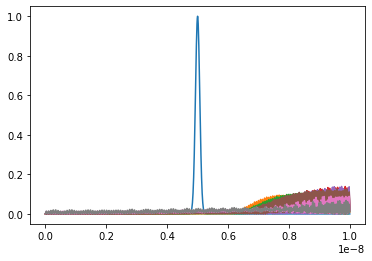

In [303]:
def psi(N, L, h, t):
    A = A_tri(N) 
    psi = initial_condition(N, L, h) #Initial wave function at time t = 0
    x = np.linspace(0, L, N+1) 
    total_steps = int(t//h)  #Number of steps to reach time t
    solution =  [psi]
    for i in range(total_steps):
        v_vector = v(psi)
        psi = Thomas(A, v_vector) #New wave function at time t + h  
        solution.append(psi) 
    return x, solution 

t = 800*h     
x, solution = psi(N, L, h, t)
plt.plot(x, abs(solution[0])**2) 
plt.plot(x, abs(solution[299])**2) 
plt.plot(x, abs(solution[350])**2) 
plt.plot(x, abs(solution[450])**2)
plt.plot(x, abs(solution[500])**2)
plt.plot(x, abs(solution[400])**2)
plt.plot(x, abs(solution[690])**2)
plt.plot(x, abs(solution[790])**2)
plt.show()

### Question 4


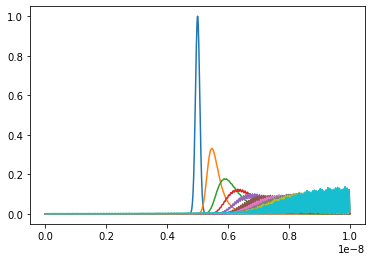

In [305]:
def psi_linlag(N, L, h, t):
    A = A(N) 
    psi = initial_condition(N, L, h) #Initial wave function at time t = 0
    x = np.linspace(0, L, N+1) 
    total_steps = int(t//h)  #Number of steps to reach time t
    solution =  [psi]
    for i in range(total_steps):
        v_vector = v(psi)
        psi = np.linalg.solve(A, v_vector) #New wave function at time t + h  
        solution.append(psi) 
    return x, solution 
t = 500*h     
x, solution = psi(N, L, h, t)

for i in range(10):
    plt.plot(x, abs(solution[i*50])**2) 

plt.show()

### Question 5

## Références
1. Newman, Mark. Computational physics. CreateSpace Independent Publ., 2013.